<a href="https://colab.research.google.com/github/jblock312/stunning-goggles/blob/main/Manager1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as npy
import os
import io
import pathlib
import seaborn as sns



In [52]:
seed = 1
tf.random.set_seed(seed)
npy.random.seed(seed)

In [53]:
DATASET_PATH = r'C:\Users\Kristen\Desktop\DataSets\TrainingFiles\Manager1'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'Manager1',
      origin = 'C:/Users/Kristen/Desktop/DataSets/TrainingFiles/Manager1',
      extract = True,
      cache_dir = 'C:/Users/Kristen/Desktop/DataSets/TrainingFiles/Manager1/',
)

commands = npy.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]


NotFoundError: Could not find directory C:\Users\Kristen\Desktop\DataSets\TrainingFiles\Manager1

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    batch_size = x,
    validation_split = 0.1,
    seed = 0,
    subset = 'train'
)

In [ ]:
train_ds.element_spec
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis = -1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards = 2, index = 0)
val_ds = val_ds.shard(num_shards = 2, index = 1)


NameError: name 'input_shape' is not defined

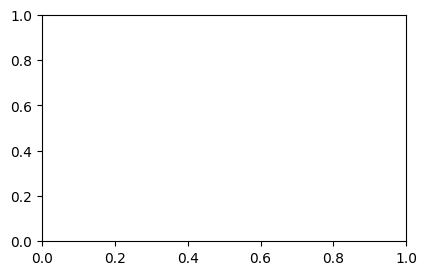

In [56]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.sft(waveform, frame_length = 255, frame_step = 128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[tf.newaxis]
  return spectrogram


plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = input_shape[i]
    plt.plot(audio_signal)
    plt.title(label_names[transcrption[i]])
    plt.yticks(npy.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])


for i in range(3):
    label = label_names[prediction_label[i]]
    waveform = input_shape[i]
    spectrogram = get_spectrogram(waveform)

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = npy.squeeze(spectrogram, axis = -1)
    log_spec = npy.log(spectrogram.T + npyfinfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = npy.linspace(0, npy.size(spectrogram), num = width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = npy.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))



In [57]:
def make_spec_ds(ds):
  return ds.map(
      map_func = lambda audia, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [58]:
train_specrtogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

for example_spectrograms, example_spect_labels in train_specrtogram_ds.take(1):
  break

NameError: name 'train_spectrogram_ds' is not defined

In [59]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data = train_spectrogram_ds.map(map_func = lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layer.Input(shape = input_shape),
    tf.keras.layer.Resizing(32, 32),
    norm_layer,
    tf.keras.layer.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layer.Dropout(0.25),
    tf.keras.layer.Flatten(),
    tf.keras.layer.Dense(128, activation='relu'),
    tf.keras.layer.Dropout(0.5),
    tf.keras.layer.Dense(num_labels),
])

model.summary()




NameError: name 'example_spectrograms' is not defined

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs = EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2),

)

In [60]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*npy.array(metrics['accuracy']), 100*npy.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

model.evaluate(test_spectrogram_ds, return_dict = True)


NameError: name 'history' is not defined

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred= tf.argmax(y_pred, axis = 1)
y_true = tf. concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis = 0)

 confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
 plt.figure(figsize = (10, 8))
 sns.heatmap(confusion_mtx,
             xticklabels = label_names,
             yticklabels = label_names,
             annot = True, fmt = 'g')
 plt.xlabel('Prediction')
 plt.ylabel('Label')
 plt.show

In [ ]:
#class ExportModel(tf.Module):
#  def __init__(self, model):
 #   self.model = model
#
    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
 #   self.__call__.get_concrete_function(
  #      x=tf.TensorSpec(shape=(), dtype=tf.string))
   # self.__call__.get_concrete_function(
  #     x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


 # @tf.function
 # def __call__(self, x):
    # If they pass a string, load the file and decode it.
 #   if x.dtype == tf.string:
  #    x = tf.io.read_file(x)
   #   x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    #  x = tf.squeeze(x, axis=-1)
 #     x = x[tf.newaxis, :]

  #  x = get_spectrogram(x)
  #  result = self.model(x, training=False)

   # class_ids = tf.argmax(result, axis=-1)
   # class_names = tf.gather(label_names, class_ids)
  #  return {'predictions':result,
          #  'class_ids': class_ids,
          #  'class_names': class_names}

In [ ]:
#export = ExportModel(model)
#export(tf.constant(str(data_dir/